In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import glob
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from time import time
from torchsummary import summary
import math

In [2]:
test_size1 = 0.4
test_size2 = 0.5
batch_size = 64
seed = 0
lr = 0.001
numepoch = 150
num_filters = [5,5]
kernel_size = 5
first_layer_neurons = 1000
second_layer_neurons = 50
torch.manual_seed(seed)
optimizer = torch.optim.Adam
loss_function = nn.MSELoss()

In [3]:
classes = ('English', 'Mandarin', 'Persian')

# Get dataset
train_data = torchvision.datasets.ImageFolder(root="./train/", transform=transforms.ToTensor())
valid_data = torchvision.datasets.ImageFolder(root="./valid/", transform=transforms.ToTensor())
test_data = torchvision.datasets.ImageFolder(root="./test/", transform=transforms.ToTensor())

In [4]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layers = [nn.Conv2d(3, num_filters[0], kernel_size = kernel_size)]
        for i in range(1,len(num_filters)):
            self.conv_layers += [nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size = kernel_size)]

        self.pool = nn.MaxPool2d(2,2)
        
        self.img_size = [64,108]
        for i in range(len(num_filters)):
            self.img_size[0] = int((self.img_size[0] - kernel_size + 1)/2)
            self.img_size[1] = int((self.img_size[1] - kernel_size + 1)/2)
        
        self.fc1 = nn.Linear(num_filters[-1]*self.img_size[0]*self.img_size[1], first_layer_neurons)
        self.fc2 = nn.Linear(first_layer_neurons, second_layer_neurons)
        self.fc3 = nn.Linear(second_layer_neurons, 3)
        self.fc1_BN = nn.BatchNorm1d(first_layer_neurons)
        self.fc2_BN = nn.BatchNorm1d(second_layer_neurons)
        
    def forward(self, x):
        for layer in self.conv_layers:
            x = self.pool(F.relu(layer(x)))
        
        x = x.view(-1,num_filters[-1]*self.img_size[0]*self.img_size[1])
        x = F.relu(self.fc1_BN(self.fc1(x)))
        x = F.relu(self.fc2_BN(self.fc2(x)))
        x = self.fc3(x)
        return x

#one hot encoding for label vector, used for MSELoss
def onehot(labels):
    one_hot_labels = np.zeros((len(labels),3))
    for i in range(len(labels)):
        one_hot_labels[i][labels[i]] = 1
    return torch.from_numpy(one_hot_labels)

#compute accuracy of the given model on data in loader
def accuracy(net, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
net = Net()
optimizer = optimizer(net.parameters(),lr)

In [6]:
trainLossRec = []
validLossRec = []
testLossRec = []
trainAccRec = []
validAccRec = []
testAccRec = []
nRec = []
startTime = time()
best_accuV = 0

for epoch in range(numepoch):
    running_loss = 0.0
    numbatch = 0
    net.train()
    for i, train_data in enumerate(train_loader, 0):
        inputs, labels = train_data
        optimizer.zero_grad()
        predictT = net(inputs.float())
        lossT= loss_function(input=predictT.squeeze(), target=onehot(labels).float())
        lossT.backward()
        optimizer.step()
        running_loss += lossT.item()
        numbatch += 1
    trainLossRec.append(running_loss/numbatch)
    accuT = accuracy(net,train_loader)
    trainAccRec.append(accuT)
    
    running_loss = 0.0
    numbatch = 0
    net.eval()
    for i, valid_data in enumerate(valid_loader):
        inputs, labels = valid_data
        predictV = net(inputs.float())
        lossV = loss_function(input=predictV.squeeze(), target=onehot(labels).float())
        running_loss += lossV.item()
        numbatch += 1
    validLossRec.append(running_loss/numbatch)
    accuV = accuracy(net,valid_loader)
    validAccRec.append(accuV)
    
    if (accuV > best_accuV):
            best_accuV = accuV
            best_baseline = net
    
    nRec.append(epoch)
    print("Epoch:",nRec[-1]+1,"Training Accuracy:",accuT,"Validation Accuracy:",accuV)
                              
timeElapsed = time()-startTime

print('Training Time:',timeElapsed)

C:\Users\Maxx\anaconda3\envs\ece324\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch: 1 Training Accuracy: 0.6344444444444445 Validation Accuracy: 0.3333333333333333
Epoch: 2 Training Accuracy: 0.7588888888888888 Validation Accuracy: 0.45
Epoch: 3 Training Accuracy: 0.8444444444444444 Validation Accuracy: 0.5733333333333334
Epoch: 4 Training Accuracy: 0.9222222222222223 Validation Accuracy: 0.6333333333333333
Epoch: 5 Training Accuracy: 0.9677777777777777 Validation Accuracy: 0.66
Epoch: 6 Training Accuracy: 0.9744444444444444 Validation Accuracy: 0.63
Epoch: 7 Training Accuracy: 0.9755555555555555 Validation Accuracy: 0.65
Epoch: 8 Training Accuracy: 0.9877777777777778 Validation Accuracy: 0.6
Epoch: 9 Training Accuracy: 0.9877777777777778 Validation Accuracy: 0.6133333333333333
Epoch: 10 Training Accuracy: 0.9922222222222222 Validation Accuracy: 0.6333333333333333
Epoch: 11 Training Accuracy: 0.9911111111111112 Validation Accuracy: 0.6366666666666667
Epoch: 12 Training Accuracy: 0.9922222222222222 Validation Accuracy: 0.6533333333333333
Epoch: 13 Training Accur

Epoch: 105 Training Accuracy: 0.9988888888888889 Validation Accuracy: 0.6666666666666666
Epoch: 106 Training Accuracy: 0.9988888888888889 Validation Accuracy: 0.6266666666666667
Epoch: 107 Training Accuracy: 0.9977777777777778 Validation Accuracy: 0.6233333333333333
Epoch: 108 Training Accuracy: 1.0 Validation Accuracy: 0.6366666666666667
Epoch: 109 Training Accuracy: 0.9988888888888889 Validation Accuracy: 0.64
Epoch: 110 Training Accuracy: 0.9955555555555555 Validation Accuracy: 0.63
Epoch: 111 Training Accuracy: 0.9988888888888889 Validation Accuracy: 0.61
Epoch: 112 Training Accuracy: 0.9966666666666667 Validation Accuracy: 0.64
Epoch: 113 Training Accuracy: 0.9988888888888889 Validation Accuracy: 0.6233333333333333
Epoch: 114 Training Accuracy: 0.9988888888888889 Validation Accuracy: 0.6466666666666666
Epoch: 115 Training Accuracy: 1.0 Validation Accuracy: 0.6333333333333333
Epoch: 116 Training Accuracy: 0.9988888888888889 Validation Accuracy: 0.6366666666666667
Epoch: 117 Trainin

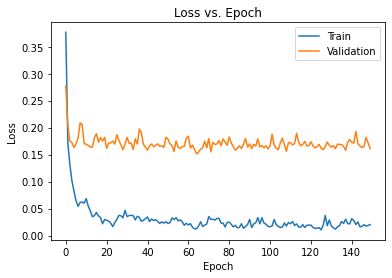

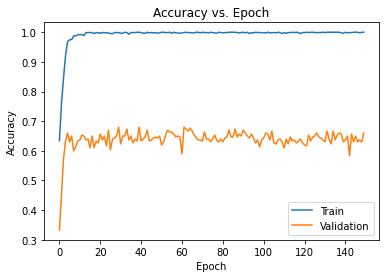

In [7]:
# PLOT
plt.plot(nRec,trainLossRec, label='Train')
plt.plot(nRec,validLossRec, label='Validation')
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(nRec,trainAccRec, label='Train')
plt.plot(nRec,validAccRec, label='Validation')
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [8]:
print("Best CNN Model")
print("Training Accuracy: ", accuracy(best_baseline, train_loader))
print("Validation Accuracy: ", accuracy(best_baseline, valid_loader))
print("Test Accuracy: ", accuracy(best_baseline, test_loader))

Best CNN Model
Training Accuracy:  1.0
Validation Accuracy:  0.66
Test Accuracy:  0.5733333333333334
